**Hackathon 8:** HealthCare Analytics

**Platform:** Analytics Vidhya

# Problem Statement

**The aim of this task was to predict the probability of 'Success' scenareo where Success was defined as the case where a registered patient ateended any one of the 3 medical camps**

For further details refer to the [problem statement](https://https://datahack.analyticsvidhya.com/contest/janatahack-healthcare-analytics/#ProblemStatement)



**Personal Remark:** Most interesting problem statement I have come across till now. If you are a beginner I urge you to dirty your hands on it. There is a lot to learn !!!! 
Hope this notebook will be helpful.

# Data Analysis

In [1]:
pip install eli5

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from datetime import datetime
from sklearn import preprocessing, model_selection, metrics, ensemble
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from eli5.sklearn import PermutationImportance

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
#Reading train and test data
train = pd.read_csv('../input/Train.csv')
test = pd.read_csv('../input/Test.csv')


In [4]:
#Let us have a look at the structure of data in each file
print("Train data structure -> ","Rows: ",train.shape[0],'\t',"Cols: ",train.shape[1])
print("Test data structure ->", "Rows: ",test.shape[0],'\t',"Cols: ",test.shape[1])


Train data structure ->  Rows:  75278 	 Cols:  8
Test data structure -> Rows:  35249 	 Cols:  8




*   Our initial train and test data have 8 columns with test data almost half the size of test data.
*   The interesting thing is we do not have a pre-defined target variable . We will be creating the target variable using the metadata provided later.



## Train Data Analysis

In [5]:
train.head(10).append(train.tail(10))

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5
0,489652,6578,10-Sep-05,4,0,0,0,2
1,507246,6578,18-Aug-05,45,5,0,0,7
2,523729,6534,29-Apr-06,0,0,0,0,0
3,524931,6535,07-Feb-04,0,0,0,0,0
4,521364,6529,28-Feb-06,15,1,0,0,7
5,494493,6570,20-May-05,0,0,0,0,0
6,523001,6562,22-May-05,0,0,0,0,0
7,500733,6535,31-Jan-04,0,0,0,0,0
8,501155,6538,31-Jan-04,0,0,0,0,0
9,501457,6538,12-Aug-04,0,0,0,0,0




> We have total of 75278 records in the training set with 5 anonymized features

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75278 entries, 0 to 75277
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Patient_ID         75278 non-null  int64 
 1   Health_Camp_ID     75278 non-null  int64 
 2   Registration_Date  74944 non-null  object
 3   Var1               75278 non-null  int64 
 4   Var2               75278 non-null  int64 
 5   Var3               75278 non-null  int64 
 6   Var4               75278 non-null  int64 
 7   Var5               75278 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 4.6+ MB




> Some of the 'Registration_Dates' are missing in the dataset , we will either need to impute these values or drop them.



In [7]:
#Let us find out the unique number of patients in train set
train.Patient_ID.nunique()

29828

**There are 29898 unique patient ID's in a dataset of 75278 records which means many patients have registered for the camps more than 1 time. Let us look at the unique number of registrations a patient has made to the camps and its distribution**



> Note : Here we are only trying to look at the number of registrations done by a patient(This does not mean the patient also attended the camp)



In [8]:
train.groupby('Patient_ID')['Health_Camp_ID'].count().unique()

array([ 2,  1,  5,  4,  8, 14,  3,  6,  7,  9, 12, 13, 10, 19, 11, 22, 16,
       18, 20, 15, 23, 17, 28, 24, 21, 32, 25])

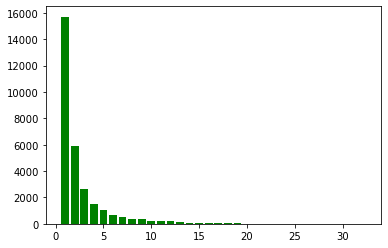

,Number_of_registrations_per_person,Count
0,1,15714
1,2,5878
2,3,2675
3,4,1527
4,5,1038
5,6,670
6,7,490
7,8,388
8,9,335
9,10,207


In [9]:
train_grouped = train.groupby('Patient_ID').agg('size').reset_index()
train_grouped.columns = ["Patient_ID", "Number_of_registrations_per_person"]
train_grouped = train_grouped.groupby('Number_of_registrations_per_person').agg('size').reset_index()
train_grouped.columns = ["Number_of_registrations_per_person", "Count"]
mpl.pyplot.bar(train_grouped.Number_of_registrations_per_person, train_grouped.Count, color='g')
mpl.pyplot.show()
train_grouped



> Number of registrations vary from 1-32 and most of the patients have visited to the camps between 1-5 times.

**This is a good indicator that people having repeating behaviour of visiting camps will have a higher probability of success. We will use this to create some additional features**



In [10]:
#Handling missing values in registration date and converting to numeric type.
# There are two methods either to drop the missing dates or impute them with some old date value like '18-Jan-1900' so that model understands it is an outlier.
# The former gave better results so I will be dropping the missing dates. Also to maintain continuity I have decided to take data only after 2005 since all missing dates are before 2005.
train['Registration_Date'] = pd.to_datetime(train['Registration_Date'], format="%d-%b-%y")



In [11]:
train_indexed = train.set_index('Registration_Date')
train_indexed

,Patient_ID,Health_Camp_ID,Var1,Var2,Var3,Var4,Var5
Registration_Date,,,,,,,
2005-09-10,489652,6578,4,0,0,0,2
2005-08-18,507246,6578,45,5,0,0,7
2006-04-29,523729,6534,0,0,0,0,0
2004-02-07,524931,6535,0,0,0,0,0
2006-02-28,521364,6529,15,1,0,0,7
...,...,...,...,...,...,...,...
2005-01-03,500969,6539,0,0,0,0,0
2006-02-13,511952,6528,0,0,0,0,0
2005-05-24,521236,6554,0,0,0,0,0


In [12]:
train = train_indexed['2005':]
train = train.reset_index()
train

,Registration_Date,Patient_ID,Health_Camp_ID,Var1,Var2,Var3,Var4,Var5
0,2005-09-10,489652,6578,4,0,0,0,2
1,2005-08-18,507246,6578,45,5,0,0,7
2,2006-04-29,523729,6534,0,0,0,0,0
3,2006-02-28,521364,6529,15,1,0,0,7
4,2005-05-20,494493,6570,0,0,0,0,0
...,...,...,...,...,...,...,...,...
52838,2005-04-02,522723,6562,0,0,0,0,0
52839,2005-01-03,500969,6539,0,0,0,0,0
52840,2006-02-13,511952,6528,0,0,0,0,0
52841,2005-05-24,521236,6554,0,0,0,0,0


In [13]:
train['Registration_Date'] = train['Registration_Date'].apply(lambda x: x.toordinal())

## Test Data Analysis

In [14]:
test.head(10).append(test.tail(10))

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5
0,505701,6548,21-May-06,1,0,0,0,2
1,500633,6584,02-Jun-06,0,0,0,0,0
2,506945,6582,10-Aug-06,0,0,0,0,0
3,497447,6551,27-Aug-06,0,0,0,0,0
4,496446,6533,19-Sep-06,0,0,0,0,0
5,494067,6548,19-Jul-06,0,0,0,0,0
6,498974,6574,29-Jun-06,0,0,0,0,0
7,525212,6567,01-Feb-07,0,0,0,0,0
8,507387,6583,03-Aug-06,0,0,0,0,0
9,517714,6573,18-Sep-06,0,0,0,0,0




> We have total of 35249 records in the test set with 5 anonymized features

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35249 entries, 0 to 35248
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Patient_ID         35249 non-null  int64 
 1   Health_Camp_ID     35249 non-null  int64 
 2   Registration_Date  35249 non-null  object
 3   Var1               35249 non-null  int64 
 4   Var2               35249 non-null  int64 
 5   Var3               35249 non-null  int64 
 6   Var4               35249 non-null  int64 
 7   Var5               35249 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 2.2+ MB




> No null values in the test set



In [16]:
#Let us find out the unique number of patients in test set
test.Patient_ID.nunique()

15324

**Just like train set , test set has 15324 unique patient ID's in a dataset of 35248 records. Let us look at the unique number of registrations a patient has made to the camps**

In [17]:
test.groupby('Patient_ID')['Health_Camp_ID'].count().unique()

array([ 1,  5,  2,  4,  8,  3,  7,  6,  9, 10, 12, 13, 15, 14, 11, 17])

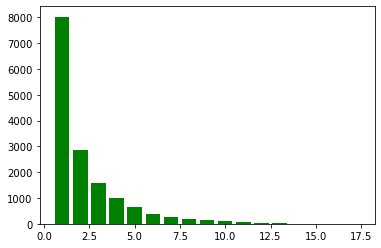

,Number_of_registrations_per_person,Count
0,1,8023
1,2,2877
2,3,1570
3,4,984
4,5,640
5,6,391
6,7,272
7,8,187
8,9,163
9,10,95


In [18]:
test_grouped = test.groupby('Patient_ID').agg('size').reset_index()
test_grouped.columns = ["Patient_ID", "Number_of_registrations_per_person"]
test_grouped = test_grouped.groupby('Number_of_registrations_per_person').agg('size').reset_index()
test_grouped.columns = ["Number_of_registrations_per_person", "Count"]
mpl.pyplot.bar(test_grouped.Number_of_registrations_per_person, test_grouped.Count, color='g')
mpl.pyplot.show()
test_grouped



> Test set follows almost similar distribution as train set as most number of patients atleast for the number of registrations made per patient



In [19]:
#Converting date to numeric
test['Registration_Date'] = pd.to_datetime(test['Registration_Date'], format="%d-%b-%y")
test['Registration_Date'] = test['Registration_Date'].apply(lambda x: x.toordinal())

## Metadata Analysis

In [20]:
# Let us now input other supporting data and have a quick analysis 

patient_data = pd.read_csv('../input/Patient_Profile.csv')
camp_data = pd.read_csv('../input/Health_Camp_Detail.csv')
FHC_attended = pd.read_csv('../input/First_Health_Camp_Attended.csv')
SHC_attended = pd.read_csv('../input/Second_Health_Camp_Attended.csv')
THC_attended = pd.read_csv('../input/Third_Health_Camp_Attended.csv')

In [21]:
print("Patient data structure -> ","Rows: ", patient_data.shape[0],'\t',"Cols: ",patient_data.shape[1])
print("Camps data structure -> ","Rows: ", camp_data.shape[0],'\t',"Cols: ",camp_data.shape[1])
print("First Format Health Camp Attended data structure ->  ","Rows: ", FHC_attended.shape[0],'\t',"Cols: ",FHC_attended.shape[1])
print("Second Format Health Camp Attended data structure ->  ","Rows: ", SHC_attended.shape[0],'\t',"Cols: ",SHC_attended.shape[1])
print("Third Format Health Camp Attended data structure ->  ","Rows: ", THC_attended.shape[0],'\t',"Cols: ",THC_attended.shape[1])

Patient data structure ->  Rows:  37633 	 Cols:  11
Camps data structure ->  Rows:  65 	 Cols:  6
First Format Health Camp Attended data structure ->   Rows:  6218 	 Cols:  5
Second Format Health Camp Attended data structure ->   Rows:  7819 	 Cols:  3
Third Format Health Camp Attended data structure ->   Rows:  6515 	 Cols:  4


In [22]:
#Let us find out what all data contains null values
dataframes = [patient_data,camp_data,FHC_attended,SHC_attended,THC_attended]
for i in dataframes:
  print(i.isnull().sum())

Patient_ID               0
Online_Follower          0
LinkedIn_Shared          0
Twitter_Shared           0
Facebook_Shared          0
Income                   0
Education_Score          0
Age                      0
First_Interaction        0
City_Type            23384
Employer_Category    34793
dtype: int64
Health_Camp_ID     0
Camp_Start_Date    0
Camp_End_Date      0
Category1          0
Category2          0
Category3          0
dtype: int64
Patient_ID           0
Health_Camp_ID       0
Donation             0
Health_Score         0
Unnamed: 4        6218
dtype: int64
Patient_ID        0
Health_Camp_ID    0
Health Score      0
dtype: int64
Patient_ID                   0
Health_Camp_ID               0
Number_of_stall_visited      0
Last_Stall_Visited_Number    0
dtype: int64




> 'City_Type' and 'Employer_Category' contains a large number of NULL values(More than 60%).It seems only logical to drop these columns.


> One more observation is the presence of column  'Unnamed:4' in First_Health_Camp.csv ...this maybe due to improper formatting of the file , so we will simply drop the columns





In [23]:
FHC_attended.head()

,Patient_ID,Health_Camp_ID,Donation,Health_Score,Unnamed: 4
0,506181,6560,40,0.439024,NaN
1,494977,6560,20,0.097561,NaN
2,518680,6560,10,0.048780,NaN
3,509916,6560,30,0.634146,NaN
4,488006,6560,20,0.024390,NaN


In [24]:
FHC_attended.drop('Unnamed: 4',axis=1,inplace = True)

In [25]:
FHC_attended.head()

,Patient_ID,Health_Camp_ID,Donation,Health_Score
0,506181,6560,40,0.439024
1,494977,6560,20,0.097561
2,518680,6560,10,0.048780
3,509916,6560,30,0.634146
4,488006,6560,20,0.024390


**Preparing Metadata for concatenating to train and test sets**

### 1.   Patient Data




In [26]:
patient_data.head()

,Patient_ID,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category
0,516956,0,0,0,0,1,90,39,18-Jun-03,NaN,Software Industry
1,507733,0,0,0,0,1,None,40,20-Jul-03,H,Software Industry
2,508307,0,0,0,0,3,87,46,02-Nov-02,D,BFSI
3,512612,0,0,0,0,1,75,47,02-Nov-02,D,Education
4,521075,0,0,0,0,3,None,80,24-Nov-02,H,Others


In [27]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37633 entries, 0 to 37632
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Patient_ID         37633 non-null  int64 
 1   Online_Follower    37633 non-null  int64 
 2   LinkedIn_Shared    37633 non-null  int64 
 3   Twitter_Shared     37633 non-null  int64 
 4   Facebook_Shared    37633 non-null  int64 
 5   Income             37633 non-null  object
 6   Education_Score    37633 non-null  object
 7   Age                37633 non-null  object
 8   First_Interaction  37633 non-null  object
 9   City_Type          14249 non-null  object
 10  Employer_Category  2840 non-null   object
dtypes: int64(5), object(6)
memory usage: 3.2+ MB


In [28]:
# City_Type and Employer_Category have lots of NULL values. We will not be using them.
# Let us now look at the different categorical variables

cat_cols = ['Income','Education_Score','Age','First_Interaction']
for i in cat_cols:
  print("Different categories in ",i," : ",'\n',patient_data[i].value_counts())




Different categories in  Income  :  
 None    33271
0        2033
1        1013
2         685
3         362
4         156
5          70
6          43
Name: Income, dtype: int64
Different categories in  Education_Score  :  
 None           36249
75                57
82                57
79                52
76                51
               ...  
88.45              1
93.87666667        1
86.75              1
87.83333333        1
82.88666667        1
Name: Education_Score, Length: 228, dtype: int64
Different categories in  Age  :  
 None    32618
41        361
43        359
42        336
40        321
39        299
44        293
45        240
38        219
72        218
46        214
73        199
47        189
37        186
71        175
74        172
48        140
49        127
36        109
50        102
51         76
70         71
52         66
35         66
53         53
75         43
34         42
54         40
69         36
55         35
76         32
56         25
58         21



> In almost all the variables large chunk of data is unknown/missing.
Since we cannot drop all the data so we will impute all of it with some large random number.



In [29]:
#Replacing None with -999
patient_data.replace('None',-999,inplace=True)

# Converting categorical columns to numeric
patient_data['Income'] = patient_data['Income'].astype('int64')
patient_data['Age'] = patient_data['Age'].astype('int64')
patient_data['Education_Score'] = patient_data['Education_Score'].astype('float64')
patient_data['First_Interaction'] = pd.to_datetime(patient_data['First_Interaction'], format="%d-%b-%y")
patient_data['First_Interaction'] = patient_data['First_Interaction'].apply(lambda x: x.toordinal())

In [30]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37633 entries, 0 to 37632
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Patient_ID         37633 non-null  int64  
 1   Online_Follower    37633 non-null  int64  
 2   LinkedIn_Shared    37633 non-null  int64  
 3   Twitter_Shared     37633 non-null  int64  
 4   Facebook_Shared    37633 non-null  int64  
 5   Income             37633 non-null  int64  
 6   Education_Score    37633 non-null  float64
 7   Age                37633 non-null  int64  
 8   First_Interaction  37633 non-null  int64  
 9   City_Type          14249 non-null  object 
 10  Employer_Category  2840 non-null   object 
dtypes: float64(1), int64(8), object(2)
memory usage: 3.2+ MB


### 2.Camps Data

In [31]:
camp_data.head()

,Health_Camp_ID,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3
0,6560,16-Aug-03,20-Aug-03,First,B,2
1,6530,16-Aug-03,28-Oct-03,First,C,2
2,6544,03-Nov-03,15-Nov-03,First,F,1
3,6585,22-Nov-03,05-Dec-03,First,E,2
4,6561,30-Nov-03,18-Dec-03,First,E,1


In [32]:
camp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Health_Camp_ID   65 non-null     int64 
 1   Camp_Start_Date  65 non-null     object
 2   Camp_End_Date    65 non-null     object
 3   Category1        65 non-null     object
 4   Category2        65 non-null     object
 5   Category3        65 non-null     int64 
dtypes: int64(2), object(4)
memory usage: 3.2+ KB


In [33]:
cat_cols = ['Camp_Start_Date','Camp_End_Date','Category1','Category2']
for i in cat_cols:
  print("Different categories in ",i," : ",'\n',camp_data[i].value_counts())

Different categories in  Camp_Start_Date  :  
 09-Jan-04    2
16-Aug-03    2
09-Nov-06    2
22-Sep-06    2
27-Sep-05    2
30-Jan-07    2
19-Feb-05    2
29-Apr-04    1
09-Oct-05    1
01-Nov-04    1
12-Oct-06    1
02-Aug-06    1
10-Feb-06    1
01-Oct-04    1
17-Dec-03    1
19-Aug-06    1
01-Feb-04    1
03-Jan-05    1
08-Apr-06    1
09-Dec-04    1
03-Nov-03    1
05-Jul-06    1
13-Jun-05    1
06-Apr-06    1
26-Apr-04    1
18-Apr-06    1
17-Oct-05    1
02-Apr-06    1
30-Mar-06    1
04-Jan-04    1
13-Jun-06    1
21-May-04    1
23-Feb-05    1
09-Sep-04    1
22-Nov-03    1
03-Dec-05    1
02-Aug-05    1
12-May-06    1
13-Nov-06    1
13-May-05    1
16-Aug-05    1
20-Sep-06    1
22-Aug-04    1
17-Sep-04    1
22-Dec-04    1
15-Sep-05    1
09-Jul-05    1
17-Aug-06    1
07-Dec-03    1
15-Feb-05    1
11-Dec-06    1
07-Aug-04    1
24-Nov-04    1
19-Jun-05    1
30-Nov-03    1
12-Oct-05    1
23-Jun-05    1
04-Aug-06    1
Name: Camp_Start_Date, dtype: int64
Different categories in  Camp_End_Date  :  
 07



> No column has any missing category. We will Label encode the two object types categories after joining with train and test data



In [34]:
#Converting date time to int
camp_data['Camp_Start_Date'] = pd.to_datetime(camp_data['Camp_Start_Date'], format="%d-%b-%y")
camp_data['Camp_Start_Date'] = camp_data['Camp_Start_Date'].apply(lambda x: x.toordinal())

camp_data['Camp_End_Date'] = pd.to_datetime(camp_data['Camp_End_Date'],format="%d-%b-%y")
camp_data['Camp_End_Date'] = camp_data['Camp_End_Date'].apply(lambda x: x.toordinal())

In [35]:
#Creating an additional feature which will tell us the duration of the camp. Higher duration means chances of higher attendance
camp_data['Camp_Duration'] = camp_data['Camp_End_Date'] - camp_data['Camp_Start_Date']


In [36]:
camp_data.head()

,Health_Camp_ID,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3,Camp_Duration
0,6560,731443,731447,First,B,2,4
1,6530,731443,731516,First,C,2,73
2,6544,731522,731534,First,F,1,12
3,6585,731541,731554,First,E,2,13
4,6561,731549,731567,First,E,1,18


### 3.First,Second and Third Camp Format Data

In [37]:
print(FHC_attended.head())
FHC_attended.info()

   Patient_ID  Health_Camp_ID  Donation  Health_Score
0      506181            6560        40      0.439024
1      494977            6560        20      0.097561
2      518680            6560        10      0.048780
3      509916            6560        30      0.634146
4      488006            6560        20      0.024390
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6218 entries, 0 to 6217
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Patient_ID      6218 non-null   int64  
 1   Health_Camp_ID  6218 non-null   int64  
 2   Donation        6218 non-null   int64  
 3   Health_Score    6218 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 194.4 KB


In [38]:
print(SHC_attended.head())
THC_attended.info()

   Patient_ID  Health_Camp_ID  Health Score
0      526631            6536      0.875136
1      509122            6536      0.755700
2      498864            6536      0.673181
3      515398            6536      0.722041
4      504624            6536      0.464712
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6515 entries, 0 to 6514
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Patient_ID                 6515 non-null   int64
 1   Health_Camp_ID             6515 non-null   int64
 2   Number_of_stall_visited    6515 non-null   int64
 3   Last_Stall_Visited_Number  6515 non-null   int64
dtypes: int64(4)
memory usage: 203.7 KB


In [39]:
print(THC_attended.head())
THC_attended.info()

   Patient_ID  Health_Camp_ID  Number_of_stall_visited  \
0      517875            6527                        3   
1      504692            6578                        1   
2      504692            6527                        3   
3      493167            6527                        4   
4      510954            6528                        2   

   Last_Stall_Visited_Number  
0                          1  
1                          1  
2                          1  
3                          4  
4                          2  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6515 entries, 0 to 6514
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Patient_ID                 6515 non-null   int64
 1   Health_Camp_ID             6515 non-null   int64
 2   Number_of_stall_visited    6515 non-null   int64
 3   Last_Stall_Visited_Number  6515 non-null   int64
dtypes: int64(4)
memory usage: 203.



> All 3 files data looks good. The only thing we will be doing is giving 'Health_Score' column a new name in FHC_attended and SHC_attended to make it more interpretable



In [40]:
#Renaming healthscore columns in FHC_attended and SHC_attended
FHC_attended.rename(columns = {'Health_Score':'Health_Score_Camp1'},inplace = True)
SHC_attended.rename(columns = {'Health Score':'Health_Score_Camp2'},inplace = True)
print(FHC_attended.head())
print(SHC_attended.head())

   Patient_ID  Health_Camp_ID  Donation  Health_Score_Camp1
0      506181            6560        40            0.439024
1      494977            6560        20            0.097561
2      518680            6560        10            0.048780
3      509916            6560        30            0.634146
4      488006            6560        20            0.024390
   Patient_ID  Health_Camp_ID  Health_Score_Camp2
0      526631            6536            0.875136
1      509122            6536            0.755700
2      498864            6536            0.673181
3      515398            6536            0.722041
4      504624            6536            0.464712


## Creating Target Variable

**One interesting thing about this dataset is that there is no pre-defined target variable,instead there are pre-defined rules from which we will be creating our own target variable.**

Approach:
*   Using FHC_attended,SHC_attended,THC_attended datasets create an additional feature as 'Outcome' with each row getting the value as 1. This is because all these patients have attended atleast 1 camp which means 'Success' in our case.

*   Join the three datasets with train set and after joining fill the records having 'NaNs' in Outcome column with 0. This is because NaNs indicate that the patient registered for the camps but did not visit the camp which is 'Failure' in our case.



In [41]:
FHC_attended['Outcome_1'] = 1
SHC_attended['Outcome_2'] = 1
THC_attended['Outcome_3'] = np.where(THC_attended['Number_of_stall_visited']>0,1,0)

In [42]:
print(FHC_attended.head(),'\n',SHC_attended.head(),'\n',THC_attended.head())

   Patient_ID  Health_Camp_ID  Donation  Health_Score_Camp1  Outcome_1
0      506181            6560        40            0.439024          1
1      494977            6560        20            0.097561          1
2      518680            6560        10            0.048780          1
3      509916            6560        30            0.634146          1
4      488006            6560        20            0.024390          1 
    Patient_ID  Health_Camp_ID  Health_Score_Camp2  Outcome_2
0      526631            6536            0.875136          1
1      509122            6536            0.755700          1
2      498864            6536            0.673181          1
3      515398            6536            0.722041          1
4      504624            6536            0.464712          1 
    Patient_ID  Health_Camp_ID  Number_of_stall_visited  \
0      517875            6527                        3   
1      504692            6578                        1   
2      504692            6527 

# Merging Data and Feature Engineering

In [43]:
#Merging metadata with train 
train = pd.merge(train,patient_data,on='Patient_ID',how = 'left')
train = pd.merge(train,camp_data,on='Health_Camp_ID',how = 'left')
train = pd.merge(train,FHC_attended,on=['Patient_ID','Health_Camp_ID'],how = 'left')
train = pd.merge(train,SHC_attended,on=['Patient_ID','Health_Camp_ID'],how = 'left')
train = pd.merge(train,THC_attended,on=['Patient_ID','Health_Camp_ID'],how = 'left')
train.head()

,Registration_Date,Patient_ID,Health_Camp_ID,Var1,Var2,Var3,Var4,Var5,Online_Follower,LinkedIn_Shared,...,Category3,Camp_Duration,Donation,Health_Score_Camp1,Outcome_1,Health_Score_Camp2,Outcome_2,Number_of_stall_visited,Last_Stall_Visited_Number,Outcome_3
0,732199,489652,6578,4,0,0,0,2,0,0,...,2,59,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1.0
1,732176,507246,6578,45,5,0,0,7,0,0,...,2,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,732430,523729,6534,0,0,0,0,0,0,0,...,2,751,NaN,NaN,NaN,0.402054,1.0,NaN,NaN,NaN
3,732370,521364,6529,15,1,0,0,7,0,0,...,2,4,NaN,NaN,NaN,0.845597,1.0,NaN,NaN,NaN
4,732086,494493,6570,0,0,0,0,0,0,0,...,2,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
#Creating Final Outcome column
train['Final_Outcome'] = np.where((train['Outcome_1'] == 1) | (train['Outcome_2'] == 1) | (train['Outcome_3'] == 1),1,0)

In [45]:
train.isnull().sum()

Registration_Date                0
Patient_ID                       0
Health_Camp_ID                   0
Var1                             0
Var2                             0
Var3                             0
Var4                             0
Var5                             0
Online_Follower                  0
LinkedIn_Shared                  0
Twitter_Shared                   0
Facebook_Shared                  0
Income                           0
Education_Score                  0
Age                              0
First_Interaction                0
City_Type                    23818
Employer_Category            42741
Camp_Start_Date                  0
Camp_End_Date                    0
Category1                        0
Category2                        0
Category3                        0
Camp_Duration                    0
Donation                     49764
Health_Score_Camp1           49764
Outcome_1                    49764
Health_Score_Camp2           45174
Outcome_2           

**List of the features we will be creating**


1.   *Camps_Registered_per_patient*: Number of camps a patient   has  registered for.
2.   *Patients_Registered_per_camp* :Number of patients registered per camp.
3.   *CampStart_Registration_Duration*: Duration between Camp start date and Registration date.
4.   *CampEnd_Registration_Duration*: Duration between Camp end date and Registration date.
5.   *Registration_FirstInteraction_Duration*: Duration between First Interaction and Registration date.
6.   *CampStart_FirstInteraction_Duration*: Duration between First Interaction and Camp Start date.
7.   *Has_Donated*: Whether a patient has denoted before or not.










In [46]:
train['Has_Donated'] = np.where(train['Donation']>0,1,0)

In [47]:
list_donated = []
for i,row in train.iterrows():
  if row['Has_Donated'] == 1:
    list_donated.append(row['Patient_ID'])

list_donated

[503580,
 495136,
 528322,
 519111,
 490477,
 493443,
 524586,
 491614,
 528278,
 491771,
 507031,
 499503,
 492080,
 506688,
 502902,
 495719,
 488136,
 508757,
 490686,
 511766,
 528322,
 510474,
 494559,
 491529,
 492225,
 503622,
 499996,
 518563,
 502666,
 526112,
 492351,
 527574,
 518338,
 506579,
 489695,
 501342,
 527415,
 496957,
 505485,
 490396,
 502754,
 491371,
 489742,
 508293,
 518511,
 523380,
 487217,
 510274,
 490835,
 498303,
 498743,
 504878,
 517237,
 514978,
 524309,
 493390,
 513513,
 503063,
 487889,
 521364,
 501278,
 520182,
 489913,
 501091,
 528016,
 485991,
 502674,
 505115,
 527373,
 512828,
 495615,
 513297,
 516592,
 524227,
 490180,
 489803,
 504658,
 521776,
 515705,
 494895,
 508203,
 502405,
 507362,
 519632,
 499395,
 512564,
 500284,
 492396,
 520845,
 510630,
 516000,
 503972,
 496517,
 517340,
 489177,
 516855,
 517923,
 504998,
 499830,
 496959,
 492022,
 516439,
 505405,
 525498,
 518939,
 502768,
 502645,
 509121,
 509122,
 497335,
 521073,
 

In [48]:
#Creating additional features
train['Camps_Registered_per_patient'] = train.groupby('Patient_ID')['Health_Camp_ID'].transform('count')
train['Patients_Registered_per_camp'] = train.groupby('Health_Camp_ID')['Patient_ID'].transform('count')
train['CampStart_Registration_Duration'] = train['Camp_Start_Date'] - train['Registration_Date']
train['CampEnd_Registration_Duration'] = train['Camp_End_Date'] - train['Registration_Date']
train['Registration_FirstInteraction_Duration'] = train['Registration_Date'] - train['First_Interaction']
train['CampStart_FirstInteraction_Duration'] = train['Camp_Start_Date'] - train['First_Interaction']

In [49]:
train.isnull().sum()

Registration_Date                             0
Patient_ID                                    0
Health_Camp_ID                                0
Var1                                          0
Var2                                          0
Var3                                          0
Var4                                          0
Var5                                          0
Online_Follower                               0
LinkedIn_Shared                               0
Twitter_Shared                                0
Facebook_Shared                               0
Income                                        0
Education_Score                               0
Age                                           0
First_Interaction                             0
City_Type                                 23818
Employer_Category                         42741
Camp_Start_Date                               0
Camp_End_Date                                 0
Category1                               

In [50]:
#Merging metadata with test
test = pd.merge(test,patient_data,on='Patient_ID',how = 'left')
test = pd.merge(test,camp_data,on='Health_Camp_ID',how = 'left')
test.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Online_Follower,LinkedIn_Shared,...,Age,First_Interaction,City_Type,Employer_Category,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3,Camp_Duration
0,505701,6548,732452,1,0,0,0,2,0,0,...,44,731251,E,NaN,732475,732541,Third,G,2,66
1,500633,6584,732464,0,0,0,0,0,0,1,...,41,731926,D,Consulting,732527,732532,Second,A,2,5
2,506945,6582,732533,0,0,0,0,0,0,0,...,-999,732420,NaN,NaN,732407,732987,First,F,2,580
3,497447,6551,732550,0,0,0,0,0,0,0,...,47,732548,B,NaN,732628,732633,Second,D,2,5
4,496446,6533,732573,0,0,0,0,0,0,0,...,-999,732573,B,NaN,732574,732577,First,E,2,3


In [51]:
#Creating extra features
test['Camps_Registered_per_patient'] = test.groupby('Patient_ID')['Health_Camp_ID'].transform('count')
test['Patients_Registered_per_camp'] = test.groupby('Health_Camp_ID')['Patient_ID'].transform('count')
test["CampStart_Registration_Duration"] = test["Camp_Start_Date"] - test["Registration_Date"]
test["CampEnd_Registration_Duration"] = test["Camp_End_Date"] - test["Registration_Date"]
test["Registration_FirstInteraction_Duration"] = test["Registration_Date"] - test["First_Interaction"]
test["CampStart_FirstInteraction_Duration"] = test["Camp_Start_Date"] - test["First_Interaction"]
test['Has_Donated'] = np.where(test['Patient_ID'].isin(list_donated),1,0)

In [52]:
from sklearn.preprocessing import LabelEncoder
cat_columns = []
for col in train.columns:
  if train[col].dtype == 'object':
    print(col)
    cat_columns.append(col)
    enc = preprocessing.LabelEncoder()
    full_list = list(train[col].values) + list(test[col].values)
    enc.fit(full_list)
    train[col] = enc.transform(list(train[col].values))
    test[col]  = enc.transform(list(test[col].values))

City_Type
Employer_Category
Category1
Category2


In [53]:
#Finally sorting the train dataframe ased on Registration Date and patient ID to capture any time related trand
train = train.sort_values(['Registration_Date','Patient_ID'])


# Model Building

Now that we have our train and test set prepared lets have alook at them and then prepare our model

In [54]:
train.head()

,Registration_Date,Patient_ID,Health_Camp_ID,Var1,Var2,Var3,Var4,Var5,Online_Follower,LinkedIn_Shared,...,Last_Stall_Visited_Number,Outcome_3,Final_Outcome,Has_Donated,Camps_Registered_per_patient,Patients_Registered_per_camp,CampStart_Registration_Duration,CampEnd_Registration_Duration,Registration_FirstInteraction_Duration,CampStart_FirstInteraction_Duration
1839,731947,485681,6526,0,0,0,0,0,0,0,...,NaN,NaN,0,0,1,1823,2,50,13,15
49635,731947,485811,6526,0,0,0,0,0,1,0,...,NaN,NaN,0,0,1,1823,2,50,100,102
21869,731947,486454,6526,0,0,0,0,0,0,0,...,NaN,NaN,0,0,2,1823,2,50,12,14
15745,731947,486673,6526,0,0,0,0,0,0,0,...,NaN,NaN,0,0,1,1823,2,50,13,15
27638,731947,486741,6580,0,0,0,0,0,0,0,...,NaN,NaN,1,1,2,137,-10,5,1,-9


In [55]:
test.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Online_Follower,LinkedIn_Shared,...,Category2,Category3,Camp_Duration,Camps_Registered_per_patient,Patients_Registered_per_camp,CampStart_Registration_Duration,CampEnd_Registration_Duration,Registration_FirstInteraction_Duration,CampStart_FirstInteraction_Duration,Has_Donated
0,505701,6548,732452,1,0,0,0,2,0,0,...,6,2,66,5,3020,23,89,1201,1224,1
1,500633,6584,732464,0,0,0,0,0,0,1,...,0,2,5,12,3041,63,68,538,601,1
2,506945,6582,732533,0,0,0,0,0,0,0,...,5,2,580,7,2763,-126,454,113,-13,0
3,497447,6551,732550,0,0,0,0,0,0,0,...,3,2,5,8,2180,78,83,2,80,0
4,496446,6533,732573,0,0,0,0,0,0,0,...,4,2,3,2,377,1,4,0,1,0


In [56]:
# These columns were chosen after looking at feature importances and vrious tral/error as they gave the best results.
cols_to_use = ['Income','Age','Category1','Category2','Camp_Duration','Patients_Registered_per_camp','Camps_Registered_per_patient','CampStart_Registration_Duration','CampEnd_Registration_Duration','Registration_FirstInteraction_Duration','CampStart_FirstInteraction_Duration','Has_Donated']
X = train[cols_to_use]
Y = train['Final_Outcome']

In [57]:
test_final = test[X.columns]

In [58]:
X.shape

(52843, 12)

In [59]:
Y.shape

(52843,)

In [60]:
X.isnull().sum()

Income                                    0
Age                                       0
Category1                                 0
Category2                                 0
Camp_Duration                             0
Patients_Registered_per_camp              0
Camps_Registered_per_patient              0
CampStart_Registration_Duration           0
CampEnd_Registration_Duration             0
Registration_FirstInteraction_Duration    0
CampStart_FirstInteraction_Duration       0
Has_Donated                               0
dtype: int64

In [61]:
test_final.head()

,Income,Age,Category1,Category2,Camp_Duration,Patients_Registered_per_camp,Camps_Registered_per_patient,CampStart_Registration_Duration,CampEnd_Registration_Duration,Registration_FirstInteraction_Duration,CampStart_FirstInteraction_Duration,Has_Donated
0,0,44,2,6,66,3020,5,23,89,1201,1224,1
1,1,41,1,0,5,3041,12,63,68,538,601,1
2,-999,-999,0,5,580,2763,7,-126,454,113,-13,0
3,0,47,1,3,5,2180,8,78,83,2,80,0
4,-999,-999,0,4,3,377,2,1,4,0,1,0


**Thought process behind chosing a time based validation set**



> Since all the data in test set were in future dates as compared to train set so creating a similar validation set seemed intuitive



In [62]:
#function for creating k-fold like validation sets for TS data. Since there is autocorrelation among datapoints we cannot use classical K-Fold approach
def train_test_split(k):
   train_size = int(train.shape[0] * k)
   x_tr, y_tr = X[0:train_size], Y[0:train_size]
   x_v,y_v = X[train_size:X.shape[0]], Y[train_size:X.shape[0]]
   return x_tr,y_tr,x_v,y_v


In [63]:
#ratios in which train data will be split
ratio = [0.88,0.9,0.92,0.94,0.96]

## RandomForestClassifier

In [64]:
#Applying Time Based validation(Results averaged over 5 subsets)
roc_auc = 0
for i in ratio:
  x_train,y_train,x_val,y_val = train_test_split(i)
  rf=RandomForestClassifier(n_estimators=1000,max_depth=8,min_samples_split=4,max_features='sqrt')
  model=rf.fit(x_train,y_train)
  pred_val = model.predict(x_val)
   
  print(metrics.roc_auc_score(pred_val, y_val))
  roc_auc+=metrics.roc_auc_score(pred_val, y_val)
    



print(roc_auc/5)

0.8439578713968958
0.8360160965794768
0.834156378600823
0.8044688172645478
0.8315439789460873
0.8300286285575662


In [65]:
#Fitting data to entire dataset
rf.fit(X,Y)

RandomForestClassifier(max_depth=8, max_features='sqrt', min_samples_split=4,
                       n_estimators=1000)

In [66]:
pred_rf = rf.predict_proba(test_final)
pred_rf

array([[0.31949759, 0.68050241],
       [0.29079237, 0.70920763],
       [0.90925299, 0.09074701],
       ...,
       [0.68445414, 0.31554586],
       [0.6975889 , 0.3024111 ],
       [0.33381212, 0.66618788]])

In [67]:
#storing probabilities of only success case
pred_prob_rf = []
for i in range(0,pred_rf.shape[0]):
  pred_prob_rf.append(pred_rf[i][1])

pred_prob_rf

[0.6805024134303262,
 0.7092076328673621,
 0.09074700889347016,
 0.42410575788828375,
 0.02050807296372172,
 0.7555649010970118,
 0.7390312343035624,
 0.6926867881822768,
 0.588884625743828,
 0.5024613669456873,
 0.07730572718692104,
 0.2586197982688507,
 0.091609682458055,
 0.07789712197221374,
 0.6787979685266898,
 0.9013613464394931,
 0.0198956514216439,
 0.3904817473843532,
 0.23999203682736905,
 0.9030344342783636,
 0.8188900197450356,
 0.8738449545365071,
 0.6585880401889075,
 0.4571465808464559,
 0.30738841977937503,
 0.05275128720763435,
 0.08849135455368344,
 0.42165599544959004,
 0.09340139166418328,
 0.009789098728109078,
 0.8939273192568997,
 0.6490305875253506,
 0.28135105109846353,
 0.5971671332911007,
 0.2833214539592605,
 0.6865637770220733,
 0.35202953171385815,
 0.2934963208290356,
 0.4103468175523468,
 0.34294646086296793,
 0.011874117044788112,
 0.3418168663452104,
 0.8885581988313119,
 0.009860170525133986,
 0.25922388848251426,
 0.8850363160075332,
 0.414923081529

## XGBoostClassifier

In [68]:
xgb = XGBClassifier(objective = "binary:logistic",eval_metric= 'auc',eta = 0.02,subsample = 0.8,min_child_weight = 5,colsample_bytree = 0.7,max_depth = 6)


In [69]:
#Applying Time Based validation(Results averaged over 5 subsets)
roc_auc = 0
for i in ratio:
  x_train,y_train,x_val,y_val = train_test_split(i)
  model=xgb.fit(x_train,y_train)
  pred_val = model.predict(x_val)
  
  print(metrics.roc_auc_score(pred_val, y_val))
  roc_auc+=metrics.roc_auc_score(pred_val, y_val)
    



print(roc_auc/5)

0.8439578713968958
0.8360160965794768
0.834156378600823
0.8178725018972933
0.8304417899747912
0.8324889276898562


In [70]:
xgb.fit(X,Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eta=0.02,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.0199999996,
              max_delta_step=0, max_depth=6, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [71]:
pred_xgb = xgb.predict_proba(test_final)
pred_xgb

array([[0.27346212, 0.7265379 ],
       [0.32034683, 0.67965317],
       [0.8915551 , 0.10844491],
       ...,
       [0.67922044, 0.3207796 ],
       [0.7121985 , 0.28780147],
       [0.3652203 , 0.6347797 ]], dtype=float32)

In [72]:
pred_prob_xgb = []
for i in range(0,pred_xgb.shape[0]):
  pred_prob_xgb.append(pred_xgb[i][1])

pred_prob_xgb

[0.7265379,
 0.67965317,
 0.10844491,
 0.4430955,
 0.090729,
 0.6967678,
 0.69826806,
 0.69323653,
 0.5678013,
 0.44556284,
 0.14916718,
 0.22402498,
 0.11019607,
 0.09566604,
 0.6951862,
 0.8471222,
 0.09106775,
 0.41354325,
 0.24364682,
 0.8645985,
 0.80328006,
 0.81580627,
 0.6677216,
 0.4114108,
 0.3188166,
 0.12461851,
 0.10165176,
 0.44179302,
 0.117062226,
 0.079776675,
 0.82862824,
 0.66647947,
 0.2722304,
 0.65394694,
 0.24972068,
 0.64770395,
 0.35381147,
 0.3198048,
 0.4068123,
 0.35704044,
 0.07327841,
 0.3541091,
 0.812629,
 0.079776675,
 0.28161982,
 0.85880154,
 0.42725873,
 0.6567493,
 0.079776675,
 0.10125231,
 0.33589193,
 0.69872755,
 0.6919897,
 0.092353866,
 0.6295891,
 0.37195054,
 0.67053235,
 0.39939454,
 0.7038484,
 0.6478582,
 0.6989508,
 0.6423461,
 0.6686608,
 0.83794636,
 0.6598538,
 0.6875385,
 0.095029704,
 0.7190847,
 0.09180834,
 0.11006184,
 0.31225926,
 0.6977074,
 0.122582845,
 0.6551237,
 0.65053684,
 0.34853122,
 0.4136597,
 0.2937332,
 0.42802474,

# Prepare Submission File

In [73]:
#Averaging prediction of both the models
df_solution = pd.DataFrame()
df_solution['Patient_ID'] = test.Patient_ID
df_solution['Health_Camp_ID'] = test.Health_Camp_ID
df_solution['Outcome'] = pred_prob_rf
df_solution 

,Patient_ID,Health_Camp_ID,Outcome
0,505701,6548,0.680502
1,500633,6584,0.709208
2,506945,6582,0.090747
3,497447,6551,0.424106
4,496446,6533,0.020508
...,...,...,...
35244,507261,6525,0.889714
35245,513607,6551,0.276583
35246,498160,6584,0.315546
35247,502444,6567,0.302411


In [74]:
df_solution.to_csv('rf.csv',index=False)